# Task

The [CSRankings](http://csrankings.org) site provides the ranking of top Computer Science institutes in US by weighting the number of papers published by each institute.
Our task is to develop a more insightful ranking system for the specific research field called Natural Language Processing (NLP).

![title](img/csrankings.png)

# Data Collection

Several sites provide databases for publications in Computer Science:

* [DBLP](http://dblp.uni-trier.de)
* [CiteSeerX](http://citeseerx.ist.psu.edu)
* [Google Scholar](https://scholar.google.com)
* [Semantic Scholar](https://www.semanticscholar.org) 

For NLP, there is a site called [ACL Anthology](http://www.aclweb.org/anthology/) providing a large database for peer-reviewed papers in NLP.
We use the [BibTex](https://en.wikipedia.org/wiki/BibTeX) files (`*.bib`) and the PDF files (e.g., `*.pdf`) provided by ACL Anthology for ranking top NLP institutes.


![title](img/aclanthology.png)

## Load Map

Load [bib_map.tsv](https://github.com/emorynlp/nlp-ranking/blob/master/tsv/bib_map.tsv) in the TSV format, where each column contains:

* The ID of a conference/journal (e.g., `'P17-1'` &rarr; ACL 2017).
* The weight of this conference/journal.
* The series of the conference/journal (e.g., ACL: long).

In [1]:
from types import SimpleNamespace

def load_map(map_file):
    """
    :param map_file: bib_map.tsv
    :return: a dictionary where the key is the conference/journal ID and the value is a namespace of (weight, series).
    """
    fin = open(map_file)
    d = {}

    for i, line in enumerate(fin):
        l = line.strip().split('\t')
        if len(l) == 3:
            key = l[0]
            d[key] = SimpleNamespace(weight=float(l[1]), series=l[2])

    return d

MAP_FILE = '/Users/jdchoi/Git/nlp-ranking/tsv/bib_map.tsv'  # change this to your local path
bib_map = load_map(MAP_FILE)
print(bib_map['P17-1'])

namespace(series='ACL: long', weight=3.0)


## Crawl BibTex Files

Crawl BibTex files containing the collections of papers from these conferences/journals.

In [2]:
import re
import os
import glob
import requests

def crawl_aclbib(bib_map, bib_dir):
    """
    Crawl bib files from ACL Anthology.
    :param bib_map: the output of load_map().
    :param bib_dir: the output directory where the bib files are stored.
    """
    re_bib = re.compile('<a href="([A-Z]\d\d-\d\d\d\d\.bib)">bib</a>')
    acl = 'http://www.aclweb.org/anthology'

    for k, v in bib_map.items():
        out = os.path.join(bib_dir, k + '.bib')
        if os.path.isfile(out): continue    # skip if already downloaded
        fout = open(out, 'w')
        print(out)

        root_url = os.path.join(acl, k[0], k[:3])            # http://www.aclweb.org/anthology/P/P17
        r = requests.get(os.path.join(root_url, k+'.bib'))   # http://www.aclweb.org/anthology/P/P17/P17-1.bib
        text = r.text.strip()

        if text.startswith('@'):    # bib collection is provided
            fout.write(r.text)
        else:                       # bib files are provided individually per papers
            r = requests.get(root_url)

            for bib in re_bib.findall(r.text):
                if bib[:6] in bib_map: continue     # skip specially handled workshops (e.g., CoNLL)
                rs = requests.get(os.path.join(root_url, bib))
                fout.write(rs.text)

        fout.close()
                
BIB_DIR = '/Users/jdchoi/Git/nlp-ranking/bib/'
crawl_aclbib(bib_map, BIB_DIR)
print(len(glob.glob(os.path.join(BIB_DIR, '*.bib'))))

124


Pre-downloaded BibTex files from ACL Anthology can be found here: https://github.com/emorynlp/nlp-ranking/tree/master/bib/

## Parse BibTex Files

Use [bibtexparser](https://pypi.python.org/pypi/bibtexparser) to parse and collect information from the BibTex files.

In [3]:
import bibtexparser

def get_entry_dict(bib_map, bib_dir):
    """
    :param acl_map: the output of load_map().
    :param bib_dir: the input directory where the bib files are stored.
    :return: a dictionary where the key is the publication ID (e.g., 'P17-1000') and the value is its bib entry.
    """
    bibs= {}
    for k, v in bib_map.items():
        fin = open(os.path.join(bib_dir, k+'.bib'))
        bib = bibtexparser.loads(fin.read())
        bibs.update([(entry['ID'], entry) for entry in bib.entries if 'author' in entry])

    return bibs

entry_dict = get_entry_dict(bib_map, BIB_DIR)
print(len(entry_dict))

16321


### Exercise

1. Currently, each bib entry consists of the `author` field represented by a string of all authors delimited by `'and'`:
```python
entry['author'] = 'Choi, Jinho D. and Palmer, Martha'
entry['author'] = 'Jinho D. Choi and Martha Palmer'
```
    Modify `load_bib()` such that the `author` field is represented by a list of author names, where the format of each name follows `'firstname (middlename) lastname'`.
```python
entry['author'] = ['Jinho D. Choi', 'Martha Palmer']
```

1. If the weight of the paper is `1.0`, load only ones that have greater or equal to 6 pages (in other words, discard abstract submissions).
```python
entry['pages'] = '1--10'  # 1st page to 10th page
```

In [4]:
def parse_name(name):
    if ',' in name:
        n = name.split(',')
        if len(n) == 2: return n[1].strip()+' '+n[0].strip()
    return name

print(parse_name('Choi, Jinho D.'))
print(parse_name('Jinho D. Choi'))

Jinho D. Choi
Jinho D. Choi


In [5]:
def get_entry_dict(bib_map, bib_dir):
    """
    :param bib_map: the output of load_map().
    :param bib_dir: the input directory where the bib files are stored.
    :return: a dictionary where the key is the publication ID (e.g., 'P17-1000') and the value is its bib entry.
    """
    re_pages = re.compile('(\d+)-{1,2}(\d+)')

    def parse_name(name):
        if ',' in name:
            n = name.split(',')
            if len(n) == 2: return n[1].strip() + ' ' + n[0].strip()
        return name

    def get(entry, weight, series):
        entry['author'] = [parse_name(name) for name in entry['author'].split(' and ')]
        entry['weight'] = weight
        entry['series'] = series
        return entry['ID'], entry

    def valid(entry, weight):
        if weight == 1.0:
            if 'pages' in entry:
                m = re_pages.search(entry['pages'])
                return m and int(m.group(2)) - int(m.group(1)) > 4
            return False

        return 'author' in entry

    bibs = {}
    for k, v in bib_map.items():
        fin = open(os.path.join(bib_dir, k+'.bib'))
        bib = bibtexparser.loads(fin.read())
        bibs.update([get(entry, v.weight, v.series) for entry in bib.entries if valid(entry, v.weight)])

    return bibs

entry_dict = get_entry_dict(bib_map, BIB_DIR)
print(entry_dict['K17-1023']['author'])

['Henry Y. Chen', 'Ethan Zhou', 'Jinho D. Choi']


### Exercise

Retrieve the list of publications for each author.

```python
def publications_per_author(entry_dict):
    """
    :param entry_dict: the output of get_entry_dict().
    :return: a dictionary where the key is an author name and the value is a list of author's publications.
    """
```

In [6]:
def publications_per_author(entry_dict):
    """
    :param entry_dict: the output of get_entry_dict().
    :return: a dictionary where the key is an author name and the value is a list of author's publications.
    """
    d = {}

    for k, v in entry_dict.items():
        author_list = v['author']
        for author in author_list:
            e = (v['title'], v['year'], v['weight'], len(author_list))
            d.setdefault(author, []).append(e)

    return d

author_pub = publications_per_author(entry_dict)
for t in sorted(author_pub['Jinho D. Choi'], key=lambda x: x[1])[-10:]: print(t)

('Semantics-based Graph Approach to Complex Question-Answering', '2015', 1.0, 2)
('Computational Exploration to Linguistic Structures of Future: Classification and Categorization', '2015', 1.0, 4)
('QA-It: Classifying Non-Referential It for Question Answer Pairs', '2016', 1.0, 3)
('Dynamic Feature Induction: The Last Gist to the State-of-the-Art', '2016', 3.0, 1)
('Character Identification on Multiparty Conversation: Identifying Mentions of Characters in TV Shows', '2016', 1.0, 2)
('Text-based Speaker Identification on Multiparty Dialogues Using Multi-document Convolutional Neural Networks', '2017', 1.0, 3)
('Robust Coreference Resolution and Entity Linking on Dialogues: Character Identification on TV Show Transcripts', '2017', 2.0, 3)
('Improving Document Clustering by Removing Unnatural Language', '2017', 1.0, 3)
('Lexicon Integrated CNN Models with Attention for Sentiment Analysis', '2017', 1.0, 3)
('Cross-genre Document Retrieval: Matching between Conversational and Formal Writings

### Exercise

Rank the authors by their publication scores.
If weighted, it is the sum of all publication weights; otherwise, it is the total number of publications by the authors.

```python
def rank_authors_by_publications(author_pub, weighted=True):
    """
    :param author_pub: the output of publications_per_author()
    :param weighted: if True, rank the authors by weighted publication scores; otherwise, by publication counts.
    :return: the ranked list of authors with their publication scores in descending order.
    """
```

In [7]:
def rank_authors_by_publications(author_pub, weighted=True, equal_contribution=True):
    """
    :param author_pub: the output of publications_per_author()
    :param weighted: if True, rank the authors by weighted publication scores; otherwise, by publication counts.
    :param equal_contribution: if True, the contribution of each paper is equally divided by the # of authors.
    :return: the ranked list of authors with their publication scores in descending order.
    """
    def score(pubs):
        if equal_contribution:
            return sum(pub[2]/pub[3] for pub in pubs) if weighted else sum(1/pub[3] for pub in pubs)
        else:
            return sum(pub[2] for pub in pubs) if weighted else len(pubs)   # pub[2]: weight

    return sorted([(k, score(v)) for k, v in author_pub.items()], key=lambda x: x[1], reverse=True)

In [8]:
author_ranks = rank_authors_by_publications(author_pub, weighted=False, equal_contribution=False)
for t in author_ranks[:10]: print(t)

('Pushpak Bhattacharyya', 116)
('Chris Dyer', 94)
('Qun Liu', 87)
('Iryna Gurevych', 85)
('Noah A. Smith', 84)
('Timothy Baldwin', 80)
('Yang Liu', 79)
('Ting Liu', 79)
('Ming Zhou', 69)
('Christopher D. Manning', 68)


In [9]:
author_ranks = rank_authors_by_publications(author_pub, weighted=True, equal_contribution=False)
for t in author_ranks[:10]: print(t)

('Chris Dyer', 236.0)
('Noah A. Smith', 221.0)
('Yang Liu', 191.0)
('Qun Liu', 190.0)
('Dan Klein', 190.0)
('Pushpak Bhattacharyya', 185.0)
('Ting Liu', 182.0)
('Christopher D. Manning', 176.0)
('Ming Zhou', 176.0)
('Timothy Baldwin', 171.0)


In [10]:
author_ranks = rank_authors_by_publications(author_pub, weighted=True, equal_contribution=True)
for t in author_ranks[:10]: print(t)

('Dan Klein', 77.25)
('Noah A. Smith', 67.44166666666666)
('Hinrich Sch\\"{u}tze', 66.33333333333331)
('Anders S{\\o}gaard', 65.25833333333333)
('Chris Dyer', 65.0381673881674)
('Iryna Gurevych', 60.84920634920635)
('Yang Liu', 60.772619047619045)
('Dan Roth', 59.30000000000001)
('Mirella Lapata', 58.85)
('Christopher D. Manning', 58.22604966717872)


### Exercise

Plot the publication score for a given author by years.

```python
def plot_scores_by_year(author_pub, name, weighted=True):
    """
    :param author_pub: the output of the publications_per_author()
    :param name: the full name of the author (e.g., Jinho D. Choi)
    :param weighted: if True, use weighted publication scores; otherwise,
    :return:
    """
```

In [11]:
import matplotlib.pyplot as plt

def plot_scores_by_year(author_pub, name, weighted=True):
    """
    :param author_pub: the output of the publications_per_author()
    :param name: the full name of the author (e.g., Jinho D. Choi)
    :param weighted: if True, use weighted publication scores; otherwise,
    :return:
    """
    d = {}
    for pub in author_pub[name]:
        year = pub[1]
        score = pub[2] if weighted else 1
        if year in d: d[year] += score
        else: d[year] = score

    xs, ys = zip(*[(k, v) for k, v in sorted(d.items())])
    plt.scatter(xs, ys)
    plt.plot(xs, ys)
    plt.grid(b='on')
    plt.show()

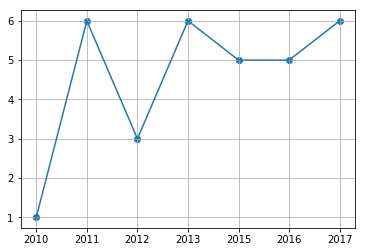

In [12]:
plot_scores_by_year(author_pub, 'Jinho D. Choi')

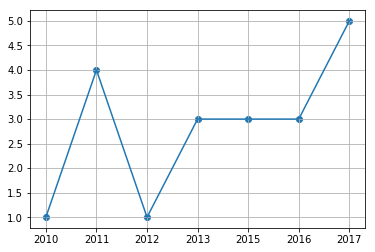

In [13]:
plot_scores_by_year(author_pub, 'Jinho D. Choi', weighted=False)

## Download PDF Files

Take URLs of the papers from the bib entries.

```python
def extract_urls(acl_map):
    for k, v in acl_map.items():
        for entry in v.entries:
            url = entry.get('url', entry.get('link', None))
            if url is not None: print(url)
```

## Extract Text from PDF Files

Use [pdftotext](https://en.wikipedia.org/wiki/Pdftotext) to extract text from the PDF files.

```bash
#!/bin/bash
IN_DIR=$1

for filename in $IN_DIR/*.pdf
do
    echo $filename
    pdftotext $filename
done
```

The pre-extracted text files can be downloaded [here](https://drive.google.com/open?id=16zdXAltl1H8LnXOGT4AIPe9iG8KjKAx5).

## Email Extraction

Extract email addresses of the authors from the text files.
Assume that email addresses are indicated within the first page of each paper.
Note that a group of emails can be also indicated (e.g., `{jinho.choi, martha.palmer}@colorado.edu`).

### Exercise

```python
def extract_emails(txt_dir):
    """
    :param txt_dir: the input directory containing all text files.
    :return: a dictionary where the key is the publication ID and the value is the list of authors' email addresses.
    """
```

In [64]:
def get_email_dict(txt_dir):
    """
    :param txt_dir: the input directory containing all text files.
    :return: a dictionary where the key is the publication ID and the value is the list of authors' email addresses.
    """
    def chunk(text_file, page_limit=2000):
        fin = codecs.open(text_file, encoding='utf-8')
        doc = []
        n = 0

        for line in fin:
            line = line.strip().lower()
            if line:
                doc.append(line)
                n += len(line)
                if n > page_limit: break

        return ' '.join(doc)

    re_email = re.compile('[({\[]?\s*([a-z0-9\.\-_]+(?:\s*[,;|]\s*[a-z0-9\.\-_]+)*)\s*[\]})]?\s*@\s*([a-z0-9\.\-_]+\.[a-z]{2,})')
    email_dict = {}

    for txt_file in glob.glob(os.path.join(txt_dir, '*.txt')):
        try:
            doc = chunk(txt_file)
        except UnicodeDecodeError:
            # print(txt_file)
            continue
        emails = []

        for m in re_email.findall(doc):
            ids = m[0].replace(';', ',').replace('|', ',')
            domain = m[1]

            if ',' in ids:
                emails.extend([ID.strip()+'@'+domain for ID in ids.split(',') if ID.strip()])
            else:
                emails.append(ids+'@'+domain)

        if emails:
            key = os.path.basename(txt_file)[:-4]
            email_dict[key] = emails

    return email_dict

TXT_DIR = '/Users/jdchoi/Git/nlp-ranking/txt/'            
email_dict = get_email_dict(TXT_DIR)
print(len(email_dict))

15594


Create a TSV file where each row represents a paper and each column indicates:

* 0: Publication ID.
* 1: Total number of the authors.
* 2+: list of email addresses.

In [65]:
def print_emails(entry_dict, email_dict, email_file):
    """
    :param entry_dict: the output of get_entry_dict().
    :param email_dict: the output of get_email_dict().
    :param email_file: the output file in the TSV format, where each column contains
                       (publication ID, the total number of authors, list of email addresses) for each paper.
    """
    fout = open(email_file, 'w')

    for k, v in sorted(entry_dict.items()):
        n = len(v['author'])
        l = [k, str(n)]
        if k in email_dict: l.extend(email_dict[k][:n])
        fout.write('\t'.join(l) + '\n')

    fout.close()

EMAIL_FILE = '/Users/jdchoi/Git/nlp-ranking/tsv/email_map.tsv'
print_emails(entry_dict, email_dict, EMAIL_FILE)

Pre-generated email file can be found here: [email_map.tsv](https://github.com/emorynlp/nlp-ranking/blob/master/tsv/email_map.tsv).

## Institution Matching

Read email information from the saved email file

In [76]:
def load_emails(email_file):
    fin = open(email_file)
    d = {}

    for line in fin:
        l = line.split('\t')
        d[l[0]] = SimpleNamespace(num_authors=int(l[1]), emails=l[2:])
    
    return d

email_dict = load_emails(EMAIL_FILE)
print(len(email_dict))

13879


Read institution information from [us_universities.tsv](https://github.com/emorynlp/nlp-ranking/blob/master/tsv/us_universities.tsv).

In [77]:
def load_institutes(institute_file):
    fin = open(institute_file)
    d = {}

    for line in fin:
        l = line.split('\t')
        d[l[1]] = SimpleNamespace(name=l[0], city=l[2], state=l[3])

    fin.close()
    return d

INSTITUTE_FILE = '/Users/jdchoi/Git/nlp-ranking/tsv/us_universities.tsv'
institute_dict = load_institutes(INSTITUTE_FILE)
print(len(institute_dict))

1923


### Exercise



In [80]:
def match_institutes(email_dict, institute_dict):
    """
    :param email_dict:
    :return:
    """
    for ID, v in email_dict.items():
        for email in v.emails:
            idx = email.rfind('@')
            domain = email[idx+1:]
            if domain.endswith('edu') and domain not in institute_dict:
                print(domain)
                
match_institutes(email_dict, institute_dict)

cs.cmu.edu
cs.pitt.edu
my.unt.edu
upf.edu
campus.upf.edu
cs.uiuc.edu
cs.uiuc.edu
cs.cmu.edu
cs.vt.edu
ist.psu.edu
ist.psu.edu
cs.utexas.edu
cs.utexas.edu
cs.utexas.edu
cs.utexas.edu
cs.nyu.edu
cs.cmu.edu
cs.cmu.edu
ict.usc.edu
ict.usc.edu
uiuc.edu
seas.upenn.edu
hlt.utdallas.edu
isi.edu
isi.edu
isi.edu
cs.fiu.edu
cs.stanford.edu
cs.toronto.edu
u.washington.edu
cs.uic.edu
hlt.utdallas.edu
hlt.utdallas.edu
cs.toronto.edu
cs.toronto.edu
cs.qc.cuny.edu
cs.cmu.edu
cs.cmu.edu
hlt.utdallas.edu
isi.edu
isi.edu
cs.utexas.edu
cs.qc.cuny.edu
my.unt.edu
cs.unt.edu
soe.ucsc.edu
soe.ucsc.edu
soe.ucsc.edu
cs.columbia.edu
ccls.columbia.edu
seas.upenn.edu
ling.osu.edu
upf.edu
upf.edu
u.washington.edu
lsi.upc.edu
lsi.upc.edu
umiacs.umd.edu
cs.umd.edu
cs.nyu.edu
cs.pitt.edu
cs.brandeis.edu
cs.uic.edu
cs.uic.edu
monash.edu
cs.columbia.edu
cs.stonybrook.edu
cs.nyu.edu
cse.psu.edu
upf.edu
upf.edu
upf.edu
hlt.utdallas.edu
cs.toronto.edu
hunter.cuny.edu
cs.columbia.edu
cslu.ogi.edu
mail.missouri.edu
cs.toront